# Self-tuned mean estimators

In [3]:
import numpy as np
from tabulate import tabulate
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sstudentt import SST
import warnings
warnings.filterwarnings('ignore')

###show all         
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions with respect to $v$ and $\tau$

In [4]:
##penalized pseudo-Huber loss function
def Ln(Y, mu, v, n, z, a):
    tau = v*np.sqrt(n)/z
    return (np.sum(np.sqrt(tau**2+np.square(Y-mu))-tau)/(z*np.sqrt(n)) + a*tau/(z*np.sqrt(n)))   

def gradient_mu(Y, mu, v, n, z, a):
    tau = v*np.sqrt(n)/z
    return -(1/(z*np.sqrt(n)))*np.sum((Y-mu)/np.sqrt(np.square(tau)+np.square(Y-mu)))

def gradient_v(Y, mu, v, n, z, a): 
    tau = v*np.sqrt(n)/z
    return (1/np.square(z))*np.sum(tau/(np.sqrt(np.square(tau)+np.square(Y-mu)))) - (n/np.square(z)-a)

##pseudo-Huber loss function
def Ln_huber(Y, mu, tau, n):
    return (np.sum(tau*np.sqrt(tau**2+np.square(Y-mu))-tau**2))/n   

def gradient_mu_huber(Y, mu, tau, n):  
    return -tau*np.sum((Y-mu)/(np.sqrt(np.square(tau)+np.square(Y-mu))))/n

## CV Huber and GD with BB-Backtracking for fixed $\tau$

In [5]:

def gd_BB_backtracking_mu(Y, tau, s1 = .01, beta1 = 0.5, gamma1 = 0.5, epsilon = 1e-6, max_iter = 1e6, verbose = False):
    """
    Gradient descent with Barzilai and Borwein method and backtracking line search.

    input:
    Y (numpy.ndarray): data
    tau (callable): robustifiation parameter
    s1: initial step size
    max_iter (int): maximum number of iterations 
    beta1 (float): backtracking parameter (0 < beta1 < 1)
    gamma1 (float): stepsize reduction parameter (0 < gamma1 < 1)
    epsilon (float): tolerance for stopping criterion

    Returns:
    tabulate of "Iteration","mu","tau","eta1","mu_prev"
    """
    ###common parameters
    tolerance  =  1e-12
    n = Y.size
    delta = 0.05
    z = np.sqrt(np.log(1/delta))
    table = []   #for storing the result

    ###algorithm initialization
    eta1 =  s1    #initialize step size
    mu = np.mean(Y)   #solution sequence for mu
   
    for i in range(int(max_iter)):
    
        ####compute loss and gradient
        fvalue = Ln_huber(Y, mu, tau, n)
        grad = gradient_mu_huber(Y, mu, tau, n)

        ####estimate step size by BB method
        if i == 0:
            delta_mu = eta1 * grad
        else:
            delta_mu = mu - mu_prev
            delta_grad = grad - grad_prev
            eta1 = np.dot(delta_mu, delta_grad) / max(tolerance,  np.dot(delta_grad, delta_grad))
            if eta1 < 1e-6:
                alpha = s1  #reset to initial step size when eta1 is too small

        ####upate eta1 by backtracking
        while Ln_huber(Y, mu - eta1 * grad, tau, n) >  Ln_huber(Y, mu, tau, n) - beta1 * eta1 * np.dot(grad, grad): #backtracking
            eta1 *= beta1 #reduce step size
    
        ###previous values
        mu_prev = mu.copy()
        grad_prev = grad.copy()
        fvalue_prev = fvalue.copy()

        ###update mu
        mu -= eta1 * grad
        fvalue = Ln_huber(Y, mu, tau, n)

        ###store the result
        table.append([i,mu_prev,tau,eta1,mu_prev]) 

        ###stopping criterion
        if abs(fvalue - fvalue_prev) / abs(fvalue_prev) < epsilon:
            break

    if verbose:
        print(tabulate(table,headers=["iter","mu","tau","eta1","mu_prev"]))
    return {"mu": mu, "iteration": i}

## Test case

In [6]:
# lognormal generation

np.random.seed(555)
n = 200
X = np.random.lognormal(0,1.5,n)-np.exp(1.5**2/2)
Y = np.random.lognormal(0,1.5,n)-np.exp(1.5**2/2)

# example gd_BB_backtracking_mu
meanList = gd_BB_backtracking_mu(Y, tau = 1, s1 = 1)
Mean = meanList["mu"]
#Loss = meanList["loss"]
Iteration = meanList["iteration"]
Mean, Iteration

(-1.834979266797568, 8)

## self-tuned mean estimators with BB and Backtracking

In [7]:
def gd_BB_backtracking(Y, a = .5, s1 = .01, s2 = .01, gamma1 = 0.5, gamma2 = 0.5, beta1 = 0.5, beta2 = 0.5, epsilon = 1e-6, max_iter = 1e6, verbose = True):
    '''
    Alternating gradient descent with Barzilai and Borwein method and backtracking line search.

    '''
    
    ###input
    tolerance  =  1e-12
    n = Y.size
    delta = 0.05
    z = np.sqrt(np.log(n/delta))
    table = []   #for storing the result
    v0, V0 = 1e-4, 1e4

    ###algorithm initialization
    eta1, eta2 =  s1, s2    #initialize step size
    mu, v = np.mean(Y), np.std(Y)   #initialize solution sequences for mu and v
   
    for i in range(int(max_iter)):

        ####################
        #####update mu######
        ####################
    
        ####compute loss and gradient
        fvalue_mu = Ln(Y, mu, v, n, z, a)
        grad_mu = gradient_mu(Y, mu, v, n, z, a)

        ####estimate step size by BB method
        if i == 0:
            delta_mu = eta1 * grad_mu
        else:
            delta_mu = mu - mu_prev
            delta_grad_mu = grad_mu - grad_mu_prev
            eta1 = np.dot(delta_mu, delta_grad_mu) / max(tolerance, np.dot(delta_grad_mu, delta_grad_mu))
            if eta1 < 1e-6:
                eta1 = s1  #reset to initial step size when eta1 is too small
        
        #print("eta1:", eta1)
        ####upate eta1 by backtracking
        while Ln(Y, mu - eta1 * grad_mu, v, n, z, a) >  Ln(Y, mu, v, n, z, a) - beta1 * eta1 * np.dot(grad_mu, grad_mu): #backtracking
            eta1 *= beta1 #reduce step size
    
        ###previous values
        mu_prev = mu.copy()
        grad_mu_prev = grad_mu.copy()
        fvalue_mu_prev = fvalue_mu.copy()

        ###update mu
        mu -= eta1 * grad_mu
        fvalue_mu = Ln(Y, mu, v, n, z, a)

        ####################
        #####update v#######
        ####################

        ####compute loss and gradient
        fvalue_v = Ln(Y, mu, v, n, z, a)
        grad_v = gradient_v(Y, mu, v, n, z, a)


        ####estimate step size by BB method
        if i == 0:
            delta_v = eta2 * grad_v
        else:
            delta_v = v - v_prev
            delta_grad_v = grad_v - grad_v_prev
            eta2 = np.dot(delta_v, delta_grad_v) / max(tolerance, np.dot(delta_grad_v, delta_grad_v))
            if eta2 < 1e-6:
                eta2 = s2  #reset to initial step size when eta1 is too small

        #print("eta2:", eta2)
        ####upate eta2 by backtracking
        while Ln(Y, mu, v - eta2 * grad_v, n, z, a) >  Ln(Y, mu, v, n, z, a)  - beta2 * eta2 * np.dot(grad_v, grad_v): #backtracking
            eta2 *= beta2 #reduce step size
    
        ###previous values
        v_prev = v.copy()
        grad_v_prev = grad_v.copy()
        fvalue_v_prev = fvalue_v.copy()

        ###update v
        v -= eta2 * grad_v
        fvalue_v = Ln(Y, mu, v, n, z, a)
    

        ###tabulate the results
        table.append([i, mu, v, grad_mu, grad_v, eta1, eta2, fvalue_mu, fvalue_v])

        ###stopping criterion
        if abs(fvalue_v - fvalue_mu_prev)/abs(fvalue_mu_prev) < epsilon:
            break
        
        ###if v too small or too large
        if v<v0 or v>V0:
            break
    
    ###verbose
    if verbose:
        print(tabulate(table,headers=["iter","mu","v", "grad_mu", "grad_v", "eta1","eta2","fvalue_mu","fvalue_v"]))
    
    return {"mu": mu, "v": v, "iteration": i}

## Test case

In [8]:
# example gd_BB_backtracking
meanList = gd_BB_backtracking(X)
#mean = meanList["mu"]
#v = meanList["v"]
#Iteration = meanList["iteration"]

  iter         mu        v      grad_mu    grad_v     eta1         eta2    fvalue_mu    fvalue_v
------  ---------  -------  -----------  --------  -------  -----------  -----------  ----------
     0  -0.447294  4.74795  0.044984     0.14976   0.01     3.63798e-14      2.36424     2.36424
     1  -0.557911  4.74795  0.0448927    0.151885  2.46403  9.09495e-15      2.36052     2.36052
     2  -0.613198  4.74795  0.022442     0.152761  2.46355  3.63798e-14      2.35959     2.35959
     3  -0.640827  4.74795  0.0112181    0.153152  2.4629   2.27374e-15      2.35935     2.35935
     4  -0.654638  4.74795  0.00560837   0.153336  2.46261  2.27374e-15      2.3593      2.3593
     5  -0.661543  4.74795  0.00280403   0.153425  2.46248  2.27374e-15      2.35928     2.35928
     6  -0.664995  4.74795  0.00140198   0.153469  2.46241  2.27374e-15      2.35928     2.35928
     7  -0.666721  4.74795  0.000700979  0.153491  2.46238  2.27374e-15      2.35928     2.35928


## Cross Validation for Huber method

In [9]:
from sklearn.model_selection import KFold

def CVhuberMean(Y, tau_seq = list(range(1,100, 1)), nfolds = 10):  
    kf = KFold(n_splits = nfolds)
    err = np.zeros(len(tau_seq))
    for i in range(len(tau_seq)):
        err_tmp = np.ones(nfolds)
        tmp = 0
        for train_index, test_index in kf.split(Y):
            mu_hat = gd_BB_backtracking_mu(Y[train_index], tau = tau_seq[i])["mu"]
            err_tmp[tmp] = np.mean((Y[test_index] - mu_hat)**2)
            tmp += 1
        err[i] = np.mean(err_tmp)

    index_min = np.argmin(err)
    mu_min = gd_BB_backtracking_mu(Y, tau_seq[index_min])["mu"]
    return {"mu" : mu_min}


In [10]:
# Test instance
CVhuberMean(Y)

{'mu': -0.5597758457693492}

## Lepski's Method

In [11]:
###find intersection of intervals
def findIntersection(intervals): ##find intersection backward
    # First interval
    N = len(intervals)
    l = intervals[N-1][0]
    r = intervals[N-1][1]
 
    # Check rest of the intervals and find the intersection
    for i in range(N-1, -1, -1):
 
        # If no intersection exists
        if (intervals[i][0] > r or intervals[i][1] < l):
            break
 
        # Else update the intersection
        else:
            l = max(l, intervals[i][0])
            r = min(r, intervals[i][1])
            
    #print("[",l,", ",r,"]")
    return([l, r])
 
# test
#findIntersection(ans)
 

In [12]:
###test###
def lepski(Y, V = 2, rho = 1.2, s = 50):

    grid = [V*rho**k for k in range(-s, s+1, 1)]
    n = Y.size
    delta =.05
    ###function###
    ans = []

    for i in range(len(grid)):
        tau = grid[i]*np.sqrt(n/np.log(1/delta))
        muHat = gd_BB_backtracking_mu(Y, tau = tau)["mu"]
        epsilon = 6*grid[i]*np.sqrt(np.log(4/delta) + np.log(2*s+1))/np.sqrt(n)
        #print("epsilon", epsilon)
        l, r = muHat - epsilon, muHat + epsilon
        #print(i, ":", [l, r])
        ans.append([l, r])
    interval = findIntersection(ans)
    return({"mu": (interval[0]+interval[1])/2.0})

##test
#V, rho, s = 10, 1.05, 100
#lepski(Y)

# MoM

In [13]:
def partition_blocks(X, K):
    """Partition X into K disjoint blocks as large as possible
    """
    # get largest block size (should be at least 1)
    n = len(X)
    B = n // K
    if B == 0:
        raise ValueError("Invalid number of blocks %s, "
                         "larger than number of samples %s" % (K, n))

    # create and return blocks (plus block size)
    np.random.shuffle(X)
    X = X[:K * B]
    blocks = np.array(np.split(X, K))

    return blocks, B

In [14]:
def MoM(X, K):
    """Compute mom estimate with K blocks
    """
    blocks, _ = partition_blocks(X, K)
    means = np.mean(blocks, axis=1)
    mom = np.median(means)

    return mom

In [15]:
# mean, var = 0.0, 1.0
# n = 1000
# X = np.random.normal(loc=mean, scale=var, size=n).reshape(-1, 1)

K = 10
B = 100

# Mean estimation
mom = MoM(X, K)
mom

-0.9108073169834825

# Trimmed mean

In [16]:
def trimmed_mean(X, eta, delta):
    half_index = int(len(X)*0.5)
    half_X = X[:half_index]
    half_Y = X[half_index:]
    N = len(half_Y)
    Y_star = np.sort(half_Y)
    epsilon = min(0.5,8*eta+12*(np.log(4/delta)/N))
    alpha = Y_star[int(epsilon*N)-1]
    beta = Y_star[int((1-epsilon)*N)-1]
    X_new = []
    for x in half_X:
        if x > beta:
            x = beta
        elif x < alpha:
            x = alpha
        X_new.append(x)
    mu = np.mean(X_new)
    return mu

## Execution Time Comparison

In [17]:
### compare simulation time
# simulation
import time
simulation_number = 1000

mu, sigma = 1, 1

####Time for our method 
start_time = time.time()
for i in tqdm(range(0,simulation_number)):
    sample = np.random.normal(mu,sigma,n)
    gd_BB_backtracking_mean_error = (gd_BB_backtracking(sample, verbose=False)["mu"]-mu)**2
stop_time = time.time()    
print("ours:--- %s seconds ---" % (stop_time - start_time))



100%|██████████| 1000/1000 [00:01<00:00, 673.70it/s]

ours:--- 1.500255823135376 seconds ---


In [18]:
print("ours:--- %s seconds ---" % (stop_time - start_time))

ours:--- 1.500255823135376 seconds ---


In [19]:
###time for Lepski's method
start_time = time.time()
for  i in tqdm(range(0,simulation_number)):
    sample = np.random.normal(mu,sigma,n)
    lepski_mean_error = (lepski(sample, V = 10)["mu"]-mu)**2
stop_time = time.time() 
print("Lepski:--- %s seconds ---" % (stop_time - start_time))

100%|██████████| 1000/1000 [00:16<00:00, 59.80it/s]

Lepski:--- 16.72393298149109 seconds ---


In [20]:
print("Lepski:--- %s seconds ---" % (stop_time  - start_time))

Lepski:--- 16.72393298149109 seconds ---


In [21]:
###time for CV Huber
start_time = time.time()
for  i in tqdm(range(0,simulation_number)):
    sample = np.random.normal(mu,sigma,n)
    cv_huber_mean_error = (CVhuberMean(sample)["mu"]-mu)**2
stop_time = time.time()   
print("CV:--- %s seconds ---" % (stop_time - start_time))

100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]

CV:--- 133.50847792625427 seconds ---


In [22]:
print("CV:--- %s seconds ---" % (stop_time - start_time))

CV:--- 133.50847792625427 seconds ---


## Functions for plotting Figure 1: estimation error vs confidence levels

In [28]:
# set up
alpha_list = [round(x,2) for x in np.arange(0.50, 1.00, 0.01)]

In [29]:
def plot_data(alpha_list, error_dict):
    sample_mean_error_list = []
    cv_huber_mean_error_list = []
    lepski_mean_error_list = []
    gd_BB_backtracking_mean_error_list = []
    MoM_mean_error_list = []
    trimmed_mean_error_list = []
    
    for alpha in alpha_list:
        sample_mean_error_list.append(np.quantile(error_dict["sample_mean_error_array"],alpha))
        cv_huber_mean_error_list.append(np.quantile(error_dict["cv_huber_mean_error_array"],alpha))
        lepski_mean_error_list.append(np.quantile(error_dict["lepski_mean_error_array"],alpha))

        gd_BB_backtracking_mean_error_list.append(np.quantile(error_dict["gd_BB_backtracking_mean_error_array"],alpha))
        MoM_mean_error_list.append(np.quantile(error_dict["MoM_mean_error_array"],alpha))
        trimmed_mean_error_list.append(np.quantile(error_dict["trimmed_mean_error_array"],alpha))
        
    return {"sample_mean_error_list":sample_mean_error_list,
            "cv_huber_mean_error_list":cv_huber_mean_error_list,
            "lepski_mean_error_list":lepski_mean_error_list,
            "gd_BB_backtracking_mean_error_list":gd_BB_backtracking_mean_error_list,
            "MoM_mean_error_list":MoM_mean_error_list,
            "trimmed_mean_error_list":trimmed_mean_error_list}

In [30]:
### Figure 1
### self-tuning vs tuning plot
def plot_fig1(alpha_list,data_dict,title):
    f = plt.figure()
    plt.plot(alpha_list, data_dict["gd_BB_backtracking_mean_error_list"], label = "ours", linestyle="-")
    plt.plot(alpha_list, data_dict["cv_huber_mean_error_list"], label = "cross validation", linestyle="-.")
    plt.plot(alpha_list, data_dict["lepski_mean_error_list"], label = "Lepski", linestyle="--")
    plt.xlabel('Confidence level')
    plt.ylabel('Estimation error')
    plt.legend()
    plt.title(title)
    plt.show()
    f.savefig("cv "+title+" figure 1.pdf", dpi=300)

### sota comparison: ours vs others 
def plot_fig1_2(alpha_list,data_dict,title):
    f = plt.figure()
    plt.plot(alpha_list, data_dict["gd_BB_backtracking_mean_error_list"], label = "ours", linestyle="-")
    plt.plot(alpha_list, data_dict["sample_mean_error_list"], label = "sample mean", linestyle="-.")
    plt.plot(alpha_list, data_dict["MoM_mean_error_list"], label = "MoM", linestyle="--")
    plt.plot(alpha_list, data_dict["trimmed_mean_error_list"], label = "trimmed mean", linestyle=":")
    plt.xlabel('Confidence level')
    plt.ylabel('Estimation error')
    plt.legend()
    plt.title(title)
    plt.show()
    f.savefig("sota "+title+" figure 1.pdf", dpi=300)


## Functions for plotting Figure 2: 99% quantiles

In [31]:
# set up
normal_sigma_list = [round(x,2) for x in np.arange(1, 4.1, 0.1)]
q_list = [round(x,2) for x in np.arange(2.5, 4.1, 0.1)]
lognormal_sigma_list = [round(x,2) for x in np.arange(0.25, 2.01, 0.01)]
shape_list = [round(x,2) for x in np.arange(1.5, 3.1, 0.1)]

In [32]:
###Fig 2: 99% quantiles
###self-tuning vs tuning
def plot_fig2(par_list,data_dict,title):
    f = plt.figure()
    plt.plot(par_list, data_dict["gd_BB_backtracking_mean_error_99quantile_array"], label = "ours", linestyle="-")
    plt.plot(par_list, data_dict["cv_huber_mean_error_99quantile_array"], label = "cross validation", linestyle="-.")
    plt.plot(par_list, data_dict["lepski_mean_error_99quantile_array"], label = "Lepski", linestyle="--")

    plt.xlabel('Parameter')
    plt.ylabel('Estimation error')
    plt.legend()
    plt.title(title)
    plt.show()
    f.savefig("cv "+title+" figure 2.pdf", dpi=300)

###sota comparison
def plot_fig2_2(par_list,data_dict,title):
    f = plt.figure()
    plt.plot(par_list, data_dict["gd_BB_backtracking_mean_error_99quantile_array"], label = "ours", linestyle="-")
    plt.plot(par_list, data_dict["sample_mean_error_99quantile_array"], label = "sample mean", linestyle="-.")
    plt.plot(par_list, data_dict["MoM_mean_error_99quantile_array"], label = "MoM", linestyle="--")
    plt.plot(par_list, data_dict["trimmed_mean_error_99quantile_array"], label = "trimmed mean", linestyle=":")
    plt.xlabel('Parameter')
    plt.ylabel('Estimation error')
    plt.legend()
    plt.title(title)
    plt.show()
    f.savefig("sota "+title+" figure 2.pdf", dpi=300)

### Normal distribution

In [34]:
# simulation
def normal_simulation(mu,sigma,n=100,simulation_number=1000):
    sample_mean_error_array = []
    cv_huber_mean_error_array = []
    lepski_mean_error_array = []

    gd_BB_backtracking_mean_error_array = []
    MoM_mean_error_array = []
    trimmed_mean_error_array = []
    
    for i in tqdm(range(0,simulation_number)):

        ####sampling
        sample = np.random.normal(mu,sigma,n)

        ####error
        sample_mean_error = abs(np.mean(sample)-mu)**2
        cv_huber_mean_error = abs(CVhuberMean(sample)["mu"]-mu)**2
        lepski_mean_error = abs(lepski(sample)["mu"]-mu)**2
        gd_BB_backtracking_mean_error = abs(gd_BB_backtracking(sample, verbose=False)["mu"]-mu)**2
        MoM_mean_error = abs(MoM(sample,K = 10)-mu)**2
        trimmed_mean_error = abs(trimmed_mean(sample,eta = 0.001, delta = 0.9)-mu)**2
        
        ####error array
        sample_mean_error_array=np.append(sample_mean_error_array,sample_mean_error)
        cv_huber_mean_error_array=np.append(cv_huber_mean_error_array,cv_huber_mean_error)
        lepski_mean_error_array=np.append(lepski_mean_error_array,lepski_mean_error)
        gd_BB_backtracking_mean_error_array=np.append(gd_BB_backtracking_mean_error_array,gd_BB_backtracking_mean_error)
        MoM_mean_error_array=np.append(MoM_mean_error_array,MoM_mean_error)
        trimmed_mean_error_array=np.append(trimmed_mean_error_array,trimmed_mean_error)

    return {
            "sample_mean_error_array":sample_mean_error_array,
            "cv_huber_mean_error_array":cv_huber_mean_error_array,
            "lepski_mean_error_array":lepski_mean_error_array,
            "gd_BB_backtracking_mean_error_array":gd_BB_backtracking_mean_error_array,
            "MoM_mean_error_array":MoM_mean_error_array,
            "trimmed_mean_error_array":trimmed_mean_error_array
            }

In [35]:
###For figure 1
sim_num = 1000

In [36]:
## data generation
mu = 0
sigma =1
normal_error_dict = normal_simulation(mu,sigma, simulation_number = sim_num)

100%|██████████| 1000/1000 [02:36<00:00,  6.38it/s]


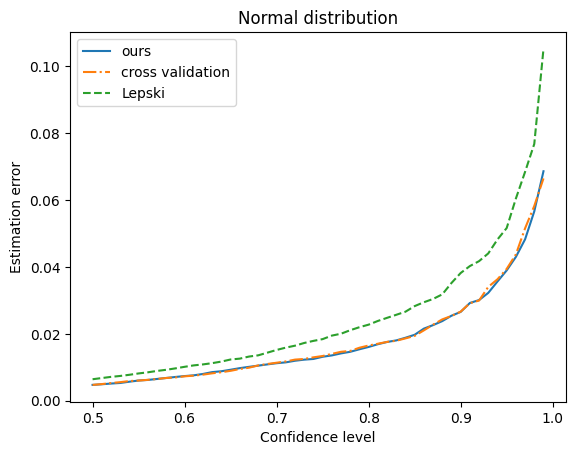

In [37]:
normal_data_dict = plot_data(alpha_list,normal_error_dict)
title = "Normal distribution"
plot_fig1(alpha_list,normal_data_dict,title)

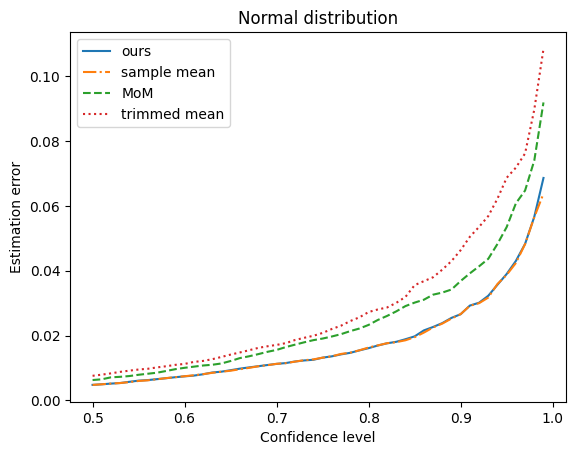

In [38]:
####sota comparison
plot_fig1_2(alpha_list,normal_data_dict,title)

### Skewed generalized t distribution

In [39]:
# simulation
def sgt_simulation(mu,sigma,lam,q,n=100,simulation_number=1000):

    sample_mean_error_array = []
    cv_huber_mean_error_array = []
    lepski_mean_error_array = []
    gd_BB_backtracking_mean_error_array = []
    MoM_mean_error_array = []
    trimmed_mean_error_array = []
    
    for i in tqdm(range(0,simulation_number)):
        sample = SST(mu, sigma, lam, q).r(n)
        sample_Y = SST(mu, sigma, lam, q).r(n)
        sample_Z = SST(mu, sigma, lam, q).r(n)
        gd_BB_backtracking_mean_error = abs(gd_BB_backtracking(sample, verbose=False)["mu"]-mu)**2
        sample_mean_error = abs(np.mean(sample)-mu)**2
        MoM_mean_error = abs(MoM(sample,K = 10)-mu)**2
        trimmed_mean_error = abs(trimmed_mean(sample,eta = 0.001, delta = 0.9)-mu)**2
        cv_huber_mean_error = abs(CVhuberMean(sample)["mu"]-mu)**2
        lepski_mean_error = abs(lepski(sample)["mu"]-mu)**2
        
        sample_mean_error_array=np.append(sample_mean_error_array,sample_mean_error)
        gd_BB_backtracking_mean_error_array=np.append(gd_BB_backtracking_mean_error_array,gd_BB_backtracking_mean_error)
        cv_huber_mean_error_array=np.append(cv_huber_mean_error_array,cv_huber_mean_error)
        lepski_mean_error_array=np.append(lepski_mean_error_array,lepski_mean_error)
        
        MoM_mean_error_array=np.append(MoM_mean_error_array,MoM_mean_error)
        trimmed_mean_error_array=np.append(trimmed_mean_error_array,trimmed_mean_error)

    return {"sample_mean_error_array":sample_mean_error_array,
            "gd_BB_backtracking_mean_error_array":gd_BB_backtracking_mean_error_array,
            "MoM_mean_error_array":MoM_mean_error_array,
            "trimmed_mean_error_array":trimmed_mean_error_array,
            "cv_huber_mean_error_array":cv_huber_mean_error_array,
            "lepski_mean_error_array":lepski_mean_error_array,
        }

In [40]:
### data generate for t distribution
mu = 0
sigma = np.sqrt(5)
lam = 0.75
q = 2.5
sgt_error_dict = sgt_simulation(mu,sigma,lam,q, simulation_number = sim_num)

100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]


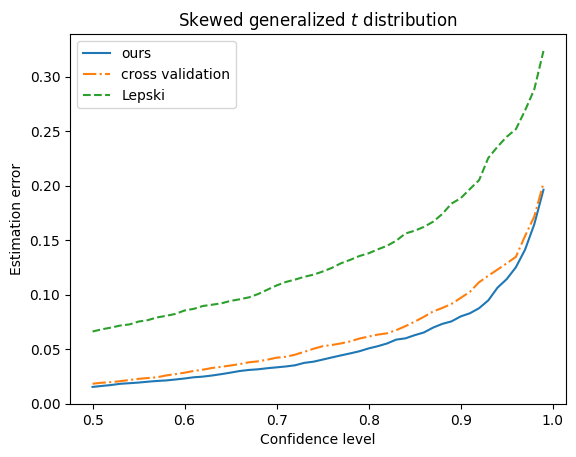

In [41]:
### self-tuning vs tuning
sgt_data_dict = plot_data(alpha_list,sgt_error_dict)
title = "Skewed generalized $t$ distribution"
plot_fig1(alpha_list,sgt_data_dict,title)

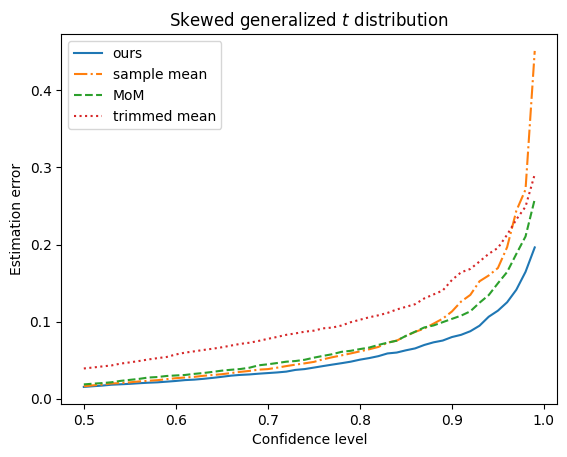

In [42]:
### self-tuning vs tuning
sgt_data_dict = plot_data(alpha_list,sgt_error_dict)
title = "Skewed generalized $t$ distribution"
plot_fig1_2(alpha_list,sgt_data_dict,title)

### Normal distribution

In [34]:
def normal_par_simulation(par_list,mu,n=100,simulation_number=100):
    
    sample_mean_error_99quantile_array = []
    gd_BB_backtracking_mean_error_99quantile_array = []
    cv_huber_mean_error_99quantile_array = []
    lepski_mean_error_99quantile_array = []
    MoM_mean_error_99quantile_array = []
    trimmed_mean_error_99quantile_array = []
    
    for par in tqdm(par_list):
        sample_mean_error_array = []
        gd_BB_backtracking_mean_error_array = []
        cv_huber_mean_error_array = []
        lepski_mean_error_array = []
        MoM_mean_error_array = []
        trimmed_mean_error_array = []
        
        for i in range(0,simulation_number):
            ###data generation
            sample = np.random.normal(mu,par,n)
            

            ####estimation error
            sample_mean_error = abs(np.mean(sample)-mu)**2
            gd_BB_backtracking_mean_error = abs(gd_BB_backtracking(sample, verbose=False)["mu"]-mu)**2
            cv_huber_mean_error = abs(CVhuberMean(sample)["mu"]-mu)**2
            lepski_mean_error = abs(lepski(sample)["mu"]-mu)**2
            MoM_mean_error = abs(MoM(sample,K = 10)-mu)**2
            trimmed_mean_error = abs(trimmed_mean(sample,eta = 0.001, delta = 0.9)-mu)**2
            
            #### array
            sample_mean_error_array=np.append(sample_mean_error_array,sample_mean_error)
            gd_BB_backtracking_mean_error_array=np.append(gd_BB_backtracking_mean_error_array,gd_BB_backtracking_mean_error)
            cv_huber_mean_error_array=np.append(cv_huber_mean_error_array,cv_huber_mean_error)
            lepski_mean_error_array=np.append(lepski_mean_error_array, lepski_mean_error)
            MoM_mean_error_array=np.append(MoM_mean_error_array,MoM_mean_error)
            trimmed_mean_error_array=np.append(trimmed_mean_error_array,trimmed_mean_error)
            
        sample_mean_error_99quantile_array = np.append(sample_mean_error_99quantile_array,np.quantile(sample_mean_error_array,0.99))
        gd_BB_backtracking_mean_error_99quantile_array = np.append(gd_BB_backtracking_mean_error_99quantile_array,np.quantile(gd_BB_backtracking_mean_error_array,0.99))
        cv_huber_mean_error_99quantile_array = np.append(cv_huber_mean_error_99quantile_array,np.quantile(cv_huber_mean_error_array,0.99))
        lepski_mean_error_99quantile_array = np.append(lepski_mean_error_99quantile_array,np.quantile(lepski_mean_error_array,0.99))
        MoM_mean_error_99quantile_array = np.append(MoM_mean_error_99quantile_array,np.quantile(MoM_mean_error_array,0.99))
        trimmed_mean_error_99quantile_array = np.append(trimmed_mean_error_99quantile_array,np.quantile(trimmed_mean_error_array,0.99))

    return {
            "sample_mean_error_99quantile_array":sample_mean_error_99quantile_array,
            "gd_BB_backtracking_mean_error_99quantile_array":gd_BB_backtracking_mean_error_99quantile_array,
            "cv_huber_mean_error_99quantile_array":cv_huber_mean_error_99quantile_array,
            "lepski_mean_error_99quantile_array":lepski_mean_error_99quantile_array,
            "MoM_mean_error_99quantile_array":MoM_mean_error_99quantile_array,
            "trimmed_mean_error_99quantile_array":trimmed_mean_error_99quantile_array
            }

In [35]:
###For figure 2
sim_num = 1000

In [36]:
mu = 0
normal_sigma_list = [round(x,2) for x in np.arange(1, 4.1, 0.1)]
normal_quantile_dict = normal_par_simulation(normal_sigma_list,mu, simulation_number = sim_num)

100%|██████████| 31/31 [1:17:02<00:00, 149.12s/it]


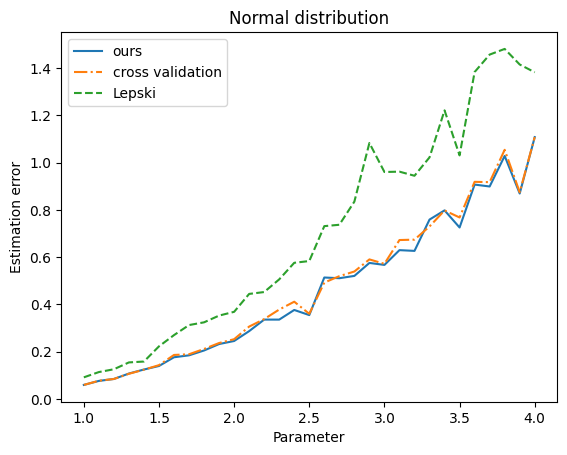

In [37]:
title = "Normal distribution"
plot_fig2(normal_sigma_list,normal_quantile_dict,title)

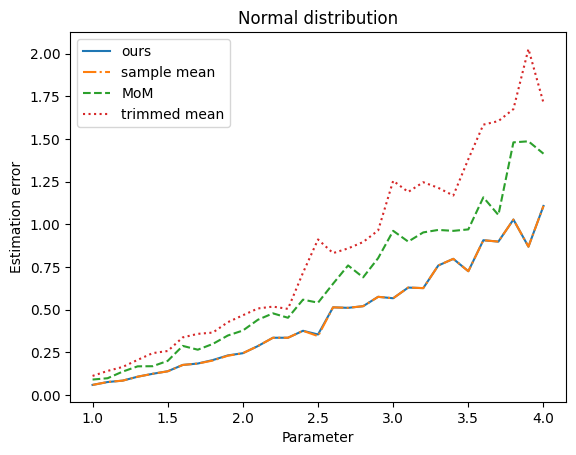

In [38]:
plot_fig2_2(normal_sigma_list,normal_quantile_dict,title)

### Skewed generalized t distribution

In [39]:
def sgt_par_simulation(par_list,mu,lam,n=100,simulation_number=100):
    
    sample_mean_error_99quantile_array = []
    cv_huber_mean_error_99quantile_array = []
    lepski_mean_error_99quantile_array = []
    gd_BB_backtracking_mean_error_99quantile_array = []
    MoM_mean_error_99quantile_array = []
    trimmed_mean_error_99quantile_array = []
    
    for par in tqdm(par_list):
        sample_mean_error_array = []
        cv_huber_mean_error_array = []
        lepski_mean_error_array = []
        gd_BB_backtracking_mean_error_array = []
        MoM_mean_error_array = []
        trimmed_mean_error_array = []
        
        for i in range(0,simulation_number):
            ### data  generation 
            sample = SST(mu, np.sqrt(par/(par-2)), lam, par).r(n)


            ##error
            sample_mean_error = abs(np.mean(sample)-mu)**2
            gd_BB_backtracking_mean_error = abs(gd_BB_backtracking(sample, s1 = 1, s2 = np.sqrt(n), verbose=False)["mu"]-mu)**2
            cv_huber_mean_error = abs(CVhuberMean(sample)["mu"]-mu)**2
            lepski_mean_error = abs(lepski(sample)["mu"]-mu)**2
            MoM_mean_error = abs(MoM(sample,K = 10)-mu)**2
            trimmed_mean_error = abs(trimmed_mean(sample,eta = 0.001, delta = 0.9)-mu)**2

            ###array
            sample_mean_error_array=np.append(sample_mean_error_array,sample_mean_error)
            gd_BB_backtracking_mean_error_array=np.append(gd_BB_backtracking_mean_error_array,gd_BB_backtracking_mean_error)
            cv_huber_mean_error_array=np.append(cv_huber_mean_error_array,cv_huber_mean_error)
            lepski_mean_error_array=np.append(lepski_mean_error_array,lepski_mean_error)
            MoM_mean_error_array=np.append(MoM_mean_error_array,MoM_mean_error)
            trimmed_mean_error_array=np.append(trimmed_mean_error_array,trimmed_mean_error)

            
        sample_mean_error_99quantile_array = np.append(sample_mean_error_99quantile_array,np.quantile(sample_mean_error_array,0.99))
        gd_BB_backtracking_mean_error_99quantile_array = np.append(gd_BB_backtracking_mean_error_99quantile_array,np.quantile(gd_BB_backtracking_mean_error_array,0.99))
        cv_huber_mean_error_99quantile_array = np.append(cv_huber_mean_error_99quantile_array,np.quantile(cv_huber_mean_error_array,0.99))
        lepski_mean_error_99quantile_array = np.append(lepski_mean_error_99quantile_array,np.quantile(lepski_mean_error_array,0.99))
        MoM_mean_error_99quantile_array = np.append(MoM_mean_error_99quantile_array,np.quantile(MoM_mean_error_array,0.99))
        trimmed_mean_error_99quantile_array = np.append(trimmed_mean_error_99quantile_array,np.quantile(trimmed_mean_error_array,0.99))

    return {"sample_mean_error_99quantile_array":sample_mean_error_99quantile_array,
            "gd_BB_backtracking_mean_error_99quantile_array":gd_BB_backtracking_mean_error_99quantile_array,
            "cv_huber_mean_error_99quantile_array":cv_huber_mean_error_99quantile_array,
            "lepski_mean_error_99quantile_array":lepski_mean_error_99quantile_array,
            "MoM_mean_error_99quantile_array":MoM_mean_error_99quantile_array,
            "trimmed_mean_error_99quantile_array":trimmed_mean_error_99quantile_array
    }

In [40]:
mu = 0
lam = 0.75
q_list = [round(x,2) for x in np.arange(2.5, 4.1, 0.1)]

In [41]:
sgt_quantile_dict = sgt_par_simulation(q_list,mu,lam, simulation_number = sim_num)

100%|██████████| 16/16 [58:51<00:00, 220.71s/it] 


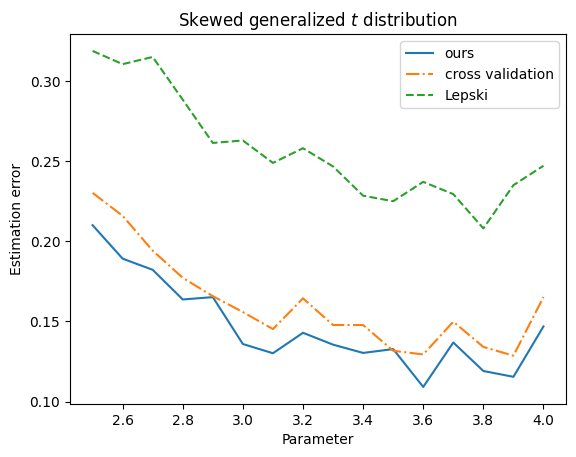

In [42]:
title = "Skewed generalized $t$ distribution"
plot_fig2(q_list,sgt_quantile_dict,title)

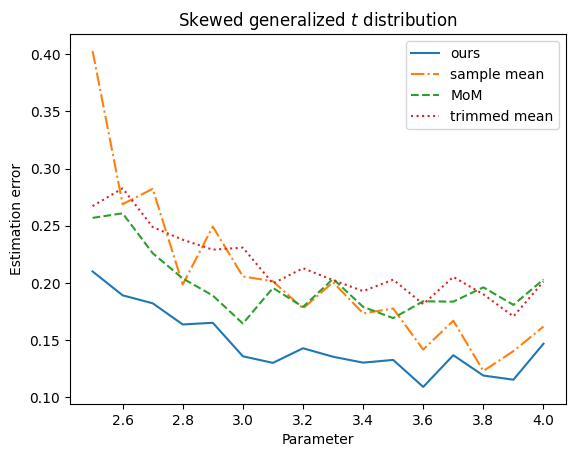

In [43]:
plot_fig2_2(q_list,sgt_quantile_dict,title)